<a href="https://colab.research.google.com/github/BStar14/Classical-Quantum_Hybird_CNN/blob/main/Boseong%20Kim/quanvolution_pennylane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Module Import, Select Device, and Download MNIST Data

### 1-1. Setup & Module Import

In [ ]:
!pip install pennylane pennylane-ionq qiskit[visualization]

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
from pennylane_ionq import ops
import matplotlib.pyplot as plt

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

### 1-2. Select Device

In [10]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    DEVICE = torch.device('cuda')
    print('cuda index:', torch.cuda.current_device())
    print('GPU:', torch.cuda.get_device_name())
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.0+cu102  Device: cpu


### 1-3. Setting of the main hyper-parameters of the model

In [36]:
BATCH_SIZE = 10
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset
learning_rate = 5e-3

SAVE_PATH = "quanvolution_pqc/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
seed = 47
np.random.seed(seed)        # Seed for NumPy random number generator
torch.manual_seed(seed)     # Seed for TensorFlow random number generator

os.environ['IONQ_API_KEY']='1LCa7Dvzz5P35g6B3gwoxzFO04n7gWYH'   # IonQ Token
#dev = qml.device("ionq.qpu", wires=9)
dev = qml.device("default.qubit", wires=9)

### 1-4. Data Loading

In [37]:
from torch.utils.data import SubsetRandomSampler
train_dataset = datasets.MNIST(root = "./mnist_data",
                               train = True,
                               download = True,
                               transform = transforms.Compose([
                                               transforms.Resize(size=14),
                                               transforms.ToTensor()]))

test_dataset = datasets.MNIST(root = "./mnist_data",
                              train = False,
                              transform = transforms.Compose([
                                              transforms.Resize(size=14),
                                              transforms.ToTensor()]))

# train_dataset = Subset(train_dataset,range(n_train))
# test_dataset = Subset(test_dataset,range(n_test))

train_sampler = SubsetRandomSampler(range(n_train))
test_sampler = SubsetRandomSampler(range(n_test))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,
                                           sampler = train_sampler)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False,
                                          sampler = test_sampler)

In [38]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([10, 1, 14, 14]) type: torch.FloatTensor
y_train: torch.Size([10]) type: torch.LongTensor


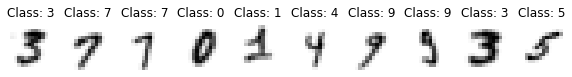

In [39]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(14, 14), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

## 2. Construct Quantum Circuit

### 2-1. Create a 'Quantum Class' with Qiskit

In [40]:
# Random circuit parameters

@qml.qnode(dev, interface='torch')
def pqc(data,params,circuit_type):
    n_qubits = 9
    for j in range(n_qubits):
        qml.RY(np.pi * data[j], wires=j)
                      
    if circuit_type == 2:     # len(params) == 18
        # PQC
        for i in range(n_qubits):
            qml.RX(params[i], wires=i)
        for i in range(n_qubits):
            qml.RX(params[i+n_qubits], wires=i)
        for i in range(n_qubits-1,0,-1):
            qml.CNOT(wires=[i,i-1])    
    elif circuit_type == 3:   # len(params) == 26
        # PQC
        for i in range(n_qubits):
            qml.RX(params[i], wires=i)
        for i in range(n_qubits):
            qml.RX(params[i+n_qubits], wires=i)
        for k,i in enumerate(range(n_qubits-1,0,-1)):
            qml.CRZ(params[k+2*n_qubits], wires=[i,i-1])
    elif circuit_type == 9:   # len(params) == 9
        # PQC
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
        for i in range(n_qubits-1,0,-1):
            qml.CZ(wires=[i,i-1])
        for i in range(n_qubits):
            qml.RX(params[i],wires=i)
    elif circuit_type == 10:  # len(params) == 18
        for i in range(n_qubits):
            qml.RY(params[i],wires=i)
        for i in range(n_qubits-1,0,-1):
            qml.CZ(wires=[i,i-1])
            qml.CZ(wires=[0,n_qubits-1])
        for i in range(n_qubits):
            qml.RY(params[i+n_qubits],wires=i)
    elif circuit_type == 'random':
        # Random quantum circuit
        rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))
        RandomLayers(rand_params, wires=list(range(4)))
    else:
        print("Invalid circuit_type")
        raise NotImplementedError
    # Measurement producing 9 classical output values
    return qml.expval(qml.PauliZ(0))

In [41]:
print(pqc(torch.tensor([1,0,2,1,2,3,1,2,0]),torch.tensor([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]), 'random'))

tensor(0.5221, dtype=torch.float64)


In [42]:
class QuanvNet(torch.nn.Module):
    def __init__(self,qc=True,opt=True,circuit_type=9):
        super().__init__()
        self.qc = qc
        self.opt = opt
        self.n_qubits = 9
        self.filters = 1
        self.conv_opt = torch.nn.Conv2d(in_channels=self.filters,out_channels=self.filters,kernel_size=3)
        self.conv1 = torch.nn.Conv2d(in_channels=self.filters,out_channels=8,kernel_size=3,padding='same')
        self.pre_pool = torch.nn.AvgPool2d(2)
        self.pool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(in_channels=8,out_channels=8,kernel_size=3)
        self.fc1 = torch.nn.Linear(32,16)
        self.fc2 = torch.nn.Linear(16,10)
        self.dropout = torch.nn.Dropout(0.4)
        if circuit_type == 2:
          self.num_q_params = 2*self.n_qubits
        elif circuit_type == 3:
          self.num_q_params = 3*self.n_qubits - 1
        elif circuit_type == 9:
          self.num_q_params = self.n_qubits
        elif circuit_type == 10:
          self.num_q_params = 2*self.n_qubits
        self.q_params = torch.nn.Parameter(2*np.pi*torch.rand(self.filters,self.num_q_params))
        self.q_params.requires_grad = True
        if self.qc:
          self.circuit_type = circuit_type
        else:
          self.circuit_type = 0

    def forward(self, inputs, check_plot=0):
        if self.qc == True:
            out = torch.zeros((BATCH_SIZE,self.filters,12,12))
            for bat, image in enumerate(inputs):
                for j in range(1, 13, 1):
                    for k in range(1, 13, 1):
                        for i in range(self.filters):
                            window = image[0, j-1:j+2, k-1:k+2].squeeze()
                            window_flatten = window.reshape(self.n_qubits)
                            q_results = pqc(
                                window_flatten,
                                self.q_params[i],
                                circuit_type=self.circuit_type
                            )
                            if use_cuda:
                              out[bat,i,j - 1, k - 1] = F.relu(q_results.cuda())
                            else:
                              out[bat,i,j - 1, k - 1] = F.relu(q_results)

            if check_plot == 1:
              pltsize = 1
              plt.figure(figsize=(BATCH_SIZE * pltsize, n_channels * pltsize))
              for i in range(BATCH_SIZE):
                for j in range(0, n_channels, 3):
                  plt.subplot((n_channels+2)/3, BATCH_SIZE, i + j*BATCH_SIZE/3 + 1)
                  plt.axis('off')
                  plt.imshow(out[i, j, :, :].reshape(12, 12), cmap = "gray_r")

        else:
          if use_cuda:
            out = torch.zeros((BATCH_SIZE,self.filters,14,14)).cuda()
          else:
            out = torch.zeros((BATCH_SIZE,self.filters,14,14))
          out = inputs
        # print(out.size())
        if self.opt==True:
          out = F.relu(self.conv_opt(inputs))
        # print("out", out.type)
        x = self.pool(F.relu(self.conv1(out)))

        # print("x", x.type)
        # print(x.size())
        # print(x.size())
        if check_plot == 1:
          conv_image = x.cpu().detach().numpy()
          pltsize = 1
          plt.figure(figsize=(BATCH_SIZE * pltsize, n_channels * pltsize))
          for i in range(BATCH_SIZE):
            for j in range(0, n_channels, 3):
              plt.subplot((n_channels+2)/3, BATCH_SIZE, i + j*BATCH_SIZE/3 + 1)
              plt.axis('off')
              plt.imshow(conv_image[i, j, :, :].reshape(6, 6), cmap = "gray_r")
        
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x))
        if use_cuda:
          return x.cuda()
        else:
          return x

In [43]:
from torchsummary import summary
criterion = torch.nn.CrossEntropyLoss()
model = QuanvNet(qc=True,opt=False)
if use_cuda:
    model.cuda()
opt = optim.Adam(model.parameters(),lr=learning_rate)
summary(model,(1,14,14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]              80
         MaxPool2d-2              [-1, 8, 6, 6]               0
            Conv2d-3              [-1, 8, 4, 4]             584
         MaxPool2d-4              [-1, 8, 2, 2]               0
            Linear-5                   [-1, 16]             528
           Dropout-6                   [-1, 16]               0
            Linear-7                   [-1, 10]             170
Total params: 1,362
Trainable params: 1,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [44]:
for p in model.parameters():
    print(p.shape)

torch.Size([1, 9])
torch.Size([1, 1, 3, 3])
torch.Size([1])
torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([16, 32])
torch.Size([16])
torch.Size([10, 16])
torch.Size([10])


In [ ]:
losses = []
accs = []
check_plot=0

for epoch in range(n_epochs):
  
  train_loss = 0
  acc = 0

  for (x_train, y_train) in train_loader:
    
    # print(y_train)

    if check_plot == 1:
      pltsize = 1
      plt.figure(figsize=(BATCH_SIZE * pltsize, pltsize))
      for i in range(BATCH_SIZE):
        plt.subplot(1, BATCH_SIZE, i + 1)
        plt.axis('off')
        plt.imshow(x_train[i, :, :, :].numpy().reshape(14, 14), cmap = "gray_r")
        plt.title('Class: ' + str(y_train[i].item()))

    opt.zero_grad()
    outputs = model(x_train.cuda() if use_cuda else x_train, check_plot=check_plot)
    _, preds = torch.max(outputs,1)
    acc += (preds==(y_train.cuda() if use_cuda else y_train)).sum().item()
    loss = criterion(outputs,(y_train.cuda() if use_cuda else y_train))
    loss.backward()
    opt.step()
    train_loss += loss
    del loss
  acc /= n_train
  train_loss /= (n_train/BATCH_SIZE)
  losses.append(train_loss.item())
  accs.append(acc)
  print(f'epoch: {epoch+1}, acc: {acc}, loss: {train_loss}')
  del acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 1, acc: 0.12, loss: 2.3022027015686035
epoch: 2, acc: 0.16, loss: 2.299938678741455
epoch: 3, acc: 0.16, loss: 2.2986063957214355
epoch: 4, acc: 0.12, loss: 2.2970006465911865


In [ ]:
from matplotlib.pyplot import plot
x = np.arange(0,1000,10)
plot(x,losses)

In [ ]:
x = np.arange(0,1000,10)
plot(x,accs)

In [ ]:
file = pd.DataFrame(data={'train_loss': losses,
                          'train_acc': accs})
file.to_pickle(file_name)